# Data Collection

0.09417033195495605


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/Users/jiaxinzhang/anaconda3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/jiaxinzhang/anaconda3/lib/python3.6/multiprocessing/pool.py", line 589, in _terminate_pool
    p.terminate()
  File "/Users/jiaxinzhang/anaconda3/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'


(array([ 156.,  389.,  603.,  770.,  934., 1268., 1943., 1786., 1374.,
         777.]),
 array([2.01164153, 2.30041567, 2.58918981, 2.87796396, 3.1667381 ,
        3.45551224, 3.74428639, 4.03306053, 4.32183467, 4.61060881,
        4.89938296]),
 <a list of 10 Patch objects>)

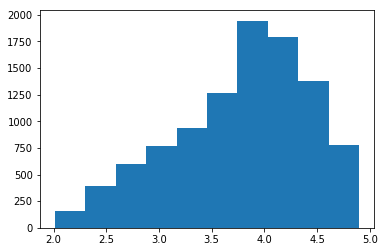

In [32]:
from math import*
import __main__
global PI
import os
import time
PI=float(acos(-1))

import random
import numpy as np
import multiprocessing as mp

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import gamma

%matplotlib inline

rs_number = 123
random.seed(rs_number)

data_size = 10000;

random_selection = 0

if random_selection==0:
    ''' random selection'''
#     mu = [0,0]
#     cov = [[1, 0], [0, 1]]
#     datasets = np.random.multivariate_normal(mu, cov, data_size)
#     X0 = np.random.uniform(1,2,data_size)
    datasets = np.random.rand(data_size,2)
else:
    '''latin hypercube sampling'''

# print(np.shape(datasets)) 
# plt.plot(datasets[:,0],datasets[:,1],'o')

def ssh(X):
    g = 4-X[0]/4 + sin(4*X[0])-X[1]
#     g = 0.7*norm.pdf(X,3,1) + 0.3*norm.pdf(X,6,1)
#     g = 0.7*norm.ppf(X, loc=3, scale=1) + 0.3*norm.ppf(X, loc=10, scale=1)
#     g = lognorm.ppf([0.001, 0.5, 0.999], X)
#     g = gamma.pdf(X, 2)
#     g = (gamma.rvs(X[0])+1)**2 + gamma.rvs(X[1])
#     g = lognorm.rvs(X[0])+lognorm.rvs(X[1])
    return g


# print(datasets)
# map async parallel 
# pool = mp.Pool(mp.cpu_count())
pool = mp.Pool(processes = 1)

start = time.time()
results_map = pool.map(ssh, datasets)
end = time.time() 
print(end - start) #0.0037827491760253906

# print(results_map)

# # rare event probability
# num = 0
# for i in range(data_size):
#     if results_map[i]<0:
#         num = num+1

# prob = num/data_size
# print(prob)

plt.hist(results_map)


# Data classification and preprocessing

In [33]:
results_map_sort = sorted(results_map) # note that sorted change the sort but didn't change the original one
# print(results_map_sort)
median_value = results_map_sort[data_size//2]
print(median_value)

results_map_new = np.zeros((data_size,1))
output_scikit = np.zeros(data_size)

for i in range(data_size):
    if results_map[i] > median_value:
        results_map_new[i,:] = 1
        output_scikit[i] = 1
    else:
        results_map_new[i,:] = 0
        output_scikit[i] = 0

y_data = output_scikit

3.8887751114251827


# Training by classification 

In [34]:
# scikit-learn MLP training 
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# preprocessing data scale? X is [1,10]
trans_mean = np.mean(datasets)
trans_std = np.std(datasets)

data_scale = 2
if data_scale==0:
    X_data = preprocessing.scale(datasets)
elif data_scale ==1:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_data = min_max_scaler.fit_transform(datasets)
elif data_scale ==2:
    scaler = preprocessing.StandardScaler().fit(datasets) # can be used for the following iteration 
    X_data = scaler.transform(datasets)  

# sgd optimizer 
# mlp = MLPClassifier(solver='sgd', activation='relu',alpha=1e-4, hidden_layer_sizes=(128, 128),
#                     random_state=1, max_iter=10000,verbose=True)

mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4, hidden_layer_sizes=(128, 128),
                    random_state=1, max_iter=1000,verbose=True,learning_rate = 'adaptive')

# lbfgs - very slow 
# mlp = MLPClassifier(solver='lbfgs', activation='relu',alpha=1e-4,hidden_layer_sizes=(100,100),
#                     random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)
# adam 
# mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(100,100),
#                     random_state=1,max_iter=50,verbose=10,learning_rate_init=.1)

# testing and training data 
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,random_state=rs_number)

# training 
mlp.fit(X_train, y_train) 

#testing
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (train) for %0.1f%% " % (accuracy * 100))

# # cross-validation 
# score_cv = cross_val_score(mlp, X_data, y_data,cv=5)  
# print(score_cv)

## tuning hyperparameters 

# 10000 data, [0.84457771 0.854      0.8385     0.845      0.85992996], default
# 10000 data, [0.82908546 0.835      0.8235     0.8185     0.82391196], feature[1,10] normalization 效果一般
# 10000 data, [0.86206897 0.8605     0.8375     0.854      0.8154077 ], feature[0,1] normalization 效果一般
# 10000 data, [0.84457771 0.854      0.8385     0.845      0.85992996], StandardScaler()

Iteration 1, loss = 0.44968690
Iteration 2, loss = 0.25229782
Iteration 3, loss = 0.14688512
Iteration 4, loss = 0.09836906
Iteration 5, loss = 0.07493393
Iteration 6, loss = 0.06181701
Iteration 7, loss = 0.05430988
Iteration 8, loss = 0.04864913
Iteration 9, loss = 0.04300831
Iteration 10, loss = 0.03902165
Iteration 11, loss = 0.03656211
Iteration 12, loss = 0.03427642
Iteration 13, loss = 0.03238535
Iteration 14, loss = 0.03169914
Iteration 15, loss = 0.02916663
Iteration 16, loss = 0.02835079
Iteration 17, loss = 0.02715110
Iteration 18, loss = 0.02716502
Iteration 19, loss = 0.02469781
Iteration 20, loss = 0.02491326
Iteration 21, loss = 0.02598180
Iteration 22, loss = 0.02293142
Iteration 23, loss = 0.02150681
Iteration 24, loss = 0.02072082
Iteration 25, loss = 0.02076171
Iteration 26, loss = 0.02100278
Iteration 27, loss = 0.02028905
Iteration 28, loss = 0.01946648
Iteration 29, loss = 0.01857285
Iteration 30, loss = 0.02004516
Iteration 31, loss = 0.01857407
Iteration 32, los

# ML rank VS FEM rank

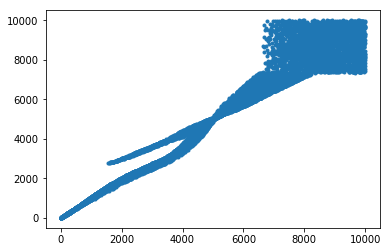

In [57]:
sort_index_FEM = np.argsort(results_map)
probs = mlp.predict_proba(X_data)
sort_index_mlp = np.argsort(probs[:][:,1])

sort_FEM = sort_index_FEM.tolist()
sort_mlp = sort_index_mlp.tolist()


# print(sort_index_FEM[1:20])
# print(sort_index_mlp[1:20])

# plt.figure()
# plt.plot(sort_index_FEM[1:10],sort_index_mlp[1:10],'x')

rank_mlp = []
for j in range(data_size):
    rank_fem = sort_FEM[j]
    rank_mlp0 = sort_mlp.index(rank_fem)
    rank_mlp.append(rank_mlp0)
#     print(rank_mlp)
   

plt.figure()
plt.plot(range(data_size),rank_mlp,'.')

#     index_mlp = np.where(sort_index_mlp==rank_fem)
#     print(index_mlp)
#     rank_mlp.append(index_mlp)
    
# print(rank_mlp)
# for i in sort_index_FEM:
#     print(i)
#     print(results_map[i])
#     print(probs[i])


# probs = mlp.predict_proba(X_data)
# sort_index_mlp = np.argsort(probs[:][:,1])

# print()

# print(sort_index_mlp)

# plt.figure()
# plt.plot(sort_index_FEM,sort_index_mlp,'x')

# plt.figure()
# plt.hist(results_map)

# Stochastic Optimization 

In [ ]:
# multiple loop training but no call FEM data collection 

loop = 10
X_loop = X_data # scale data, 50000
X_ori = datasets # orial data, 50000

for i in range(loop):
    print(i)
    # classification probability 
    probs_all = mlp.predict_proba(X_loop)
    sort_index_mlp = np.argsort(probs_all[:][:,1])

    # top 10% selection 
    top_10 = X_loop[sort_index_mlp[int(data_size*0.9):data_size]]
    top_10_ori = X_ori[sort_index_mlp[int(data_size*0.9):data_size]]
#     print(top_10_ori)

    # random selection 90%
    if random_selection==0:
        ''' random selection'''
        data_random = np.random.randint(1, 10, size=[int(data_size*0.9), 8])
    else:
        '''latin hypercube sampling'''

    X_90_scale = scaler.transform(data_random) 
    X_90_ori = data_random
    X_loop = np.concatenate((X_90_scale, top_10), axis=0)
    X_ori = np.concatenate((X_90_ori, top_10_ori), axis=0)
    

In [ ]:
datasets_test = top_10_ori

def ssh_test(num):
#     global datasets
#     arr = np.random.randint(1, 10, size=[data_size, 8])
#     datasets = arr.tolist()
    ply_angle = datasets_test[num]
    
    bas_ply=[-60, -45, -30, -15, 0, 15, 30, 45, 60, 90]

    AA1=bas_ply[ply_angle[0]]
    AA2=bas_ply[ply_angle[1]]
    AA3=bas_ply[ply_angle[2]]
    AA4=bas_ply[ply_angle[3]]
    AA5=bas_ply[ply_angle[4]]
    AA6=bas_ply[ply_angle[5]]
    AA7=bas_ply[ply_angle[6]]
    AA8=bas_ply[ply_angle[7]]

    ### ply stacking sequence###
    AAA=[AA1/180.0*PI,AA2/180.0*PI,AA3/180.0*PI,AA4/180.0*PI,AA5/180.0*PI,AA6/180.0*PI,AA7/180.0*PI,AA8/180.0*PI,AA8/180.0*PI,AA7/180.0*PI,AA6/180.0*PI,AA5/180.0*PI,AA4/180.0*PI,AA3/180.0*PI,AA2/180.0*PI,AA1/180.0*PI]
    pi=3.14159265358979

    R=250.0   ##  radius##
    H=510.0   ##  Height##
    td=0.125  #layer thickness##

    TTT=[-td*8,-td*7,-td*6,-td*5,-td*4,-td*3,-td*2,-td*1,td*0,td*1,td*2,td*3,td*4,td*5,td*6,td*7,td*8]

    ###material property###

    E1=123550.0  
    E2=8707.9
    G12=5695.0
    miu12=0.31946

    miu21=miu12*E2/E1
    Q11=E1/(1-miu12*miu21)
    Q12=miu21*E1/(1-miu12*miu21)
    Q22=E2/(1-miu12*miu21)
    Q66=G12

    A11=0.0
    A12=0.0
    A22=0.0
    A66=0.0

    D11=0.0
    D12=0.0
    D22=0.0
    D66=0.0

    for i in range(0,16):
        A11=A11+(Q11*cos(AAA[i])**4+2*(Q12+2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q22*sin(AAA[i])**4)*(TTT[i+1]-TTT[i])
        A12=A12+((Q11+Q22-4*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q12*(sin(AAA[i])**4+cos(AAA[i])**4))*(TTT[i+1]-TTT[i])
        A22=A22+(Q11*sin(AAA[i])**4+2*(Q12+2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q22*cos(AAA[i])**4)*(TTT[i+1]-TTT[i])
        A66=A66+((Q11+Q22-2*Q12-2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q66*(sin(AAA[i])**4+cos(AAA[i])**4))*(TTT[i+1]-TTT[i])
        D11=D11+(Q11*cos(AAA[i])**4+2*(Q12+2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q22*sin(AAA[i])**4)*(TTT[i+1]**3-TTT[i]**3)/3.0
        D12=D12+((Q11+Q22-4*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q12*(sin(AAA[i])**4+cos(AAA[i])**4))*(TTT[i+1]**3-TTT[i]**3)/3.0
        D22=D22+(Q11*sin(AAA[i])**4+2*(Q12+2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q22*cos(AAA[i])**4)*(TTT[i+1]**3-TTT[i]**3)/3.0
        D66=D66+((Q11+Q22-2*Q12-2*Q66)*sin(AAA[i])**2*cos(AAA[i])**2+Q66*(sin(AAA[i])**4+cos(AAA[i])**4))*(TTT[i+1]**3-TTT[i]**3)/3.0

    #####bianliang########

    D= 2*R
    L= H

    #xian
    a=[[A11,A12,0],[A12,A22,0],[0,0,A66]]
    b=[[0,0,0],[0,0,0],[0,0,0]]
    d=[[D11,D12,0],[D12,D22,0],[0,0,D66]]

    alpha=PI/L
    beta=2/D

    mm=50
    nn=50
    kmm=0
    knn=0
    kmm11=0
    knn11=0
    F=[[0 for col in range(nn)] for row in range(mm)]
    Fcr=1e16

    for m in range(1,mm+1):
        for n in range(1,nn+1):
            xi11=2*a[0][0]*(m*alpha)**2+2*a[2][2]*(n*beta)**2
            xi12=2*(a[0][1]+a[2][2])*m*alpha*n*beta
            xi13=4*a[0][1]*m*alpha/D-2*b[0][0]*(m*alpha)**3-2*(b[0][1]+2*b[2][2])*m*alpha*(n*beta)**2
            xi22=2*a[1][1]*(n*beta)**2+2*a[2][2]*(m*alpha)**2
            xi23=4*a[1][1]*n*beta/D-2*b[1][1]*(n*beta)**3-2*(b[0][1]+2*b[2][2])*(m*alpha)**2*n*beta
            xi33=4*(d[0][1]+2*d[2][2])*(m*alpha*n*beta)**2+8*a[1][1]/(D**2)\
            +2*d[0][0]*(m*alpha)**4+2*d[1][1]*(n*beta)**4-8*(b[1][1]*(n*beta)**2+b[0][1]*(m*alpha)**2)/D
            xi21=xi12
            xi31=xi13
            xi32=xi23
            det1=xi11*(xi22*xi33-xi32*xi23)-xi12*(xi21*xi33-xi31*xi23)+xi13*(xi21*xi32-xi31*xi22)
            det2=xi11*xi22-xi21*xi12
            Nx=det1/det2/(2*((m*alpha)**2))
            F[m-1][n-1]=Nx*PI*D
            if Fcr>F[m-1][n-1]:
              Fcr=F[m-1][n-1]
              kmm=m
              knn=2*n

    for m in range(1,mm+1):
        xi11=2*a[0][0]*(m*alpha)**2
        xi12=0
        xi13=4*a[0][1]*m*alpha/D-2*b[0][0]*(m*alpha)**3
        xi22=2*a[2][2]*(m*alpha)**2
        xi23=0
        xi33=8*a[1][1]/(D**2)+2*d[0][0]*(m*alpha)**4-8*b[0][1]*(m*alpha)**2/D
        xi21=xi12
        xi31=xi13
        xi32=xi23
        det1=xi11*(xi22*xi33-xi32*xi23)-xi12*(xi21*xi33-xi31*xi23)+xi13*(xi21*xi32-xi31*xi22)
        det2=xi11*xi22-xi21*xi12
        Nx=det1/det2/(2*((m*alpha)**2))
        Fn1=Nx*PI*D
        if Fcr>Fn1:
          Fcr=Fn1
          kmm=m
          knn=1

    return Fcr

In [ ]:
# pool = mp.Pool(processes = 8)
# out_opt_value = pool.map(ssh_test, range(int(data_size*0.1)))
# print(out_opt_value)
# plt.figure()
# plt.hist(out_opt_value)

out_opt_proba = mlp.predict_proba(top_10)
print(out_opt_proba[:][:,1])
plt.figure()
plt.hist(out_opt_proba[:][:,1])


plt.figure()
plt.hist(results_map)
# print(out_opt_value)
# print(out_opt_proba[:][:,1])
# print(np.shape(datasets))

# print(out_opt_value)
print(np.mean(out_opt_value))
print(np.std(out_opt_value))
print(min(out_opt_value))
print(max(out_opt_value))

In [ ]:
print(max(results_map))
print(np.mean(results_map))
print(np.std(results_map))
